# Adaptive Moment Estimation (Adam) for Deep Long Short Term Networks

## Import Dependencies

In [122]:
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import pandas as pd
import pickle
import plotly.graph_objects as go
import yaml

import json

## General Setup

In [123]:
config_file = 'config-jpy.yaml'
with open(config_file, 'rb') as file:
    config = yaml.safe_load(file)

In [124]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 156.061702,
  'MIN_DATA': 101.255919,
  'SCC': 'JPY',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

## Data Collection

- Crawling historical data dari https://ofx.com
- Visualisasi data yang telah didapatkan

In [125]:
# collect data
from utils.data_generator import ofx_dataset
from datetime import datetime
from time import time

In [126]:
start_date= config["DATA"]["START_DATE"]
end_date = config["DATA"]["END_DATE"]

In [127]:
start_date = int( datetime.combine(start_date, datetime.min.time()).timestamp() ) * 1000
end_date   = int( datetime.combine(end_date, datetime.min.time()).timestamp() ) * 1000

In [128]:
datasets = ofx_dataset(start_date, end_date, scc=config['DATA']['SCC'])

200


In [129]:
datasets['timestamps'] = pd.to_datetime(datasets['timestamps'], unit='s')
datasets.set_index('timestamps', inplace=True)
datasets.head()

,values
timestamps,
2014-04-30,112.348267
2014-05-01,112.972555
2014-05-02,112.685560
2014-05-03,112.763388
2014-05-04,112.763012


In [130]:
datasets.shape

(3243, 1)

### Function visualisasi data

In [131]:
def linechart(data: pd.DataFrame):
    plt.plot(data.index, datasets.values)
    plt.xlabel("Histories")
    plt.ylabel("Values")
    plt.title("Historical Data")
    plt.show()

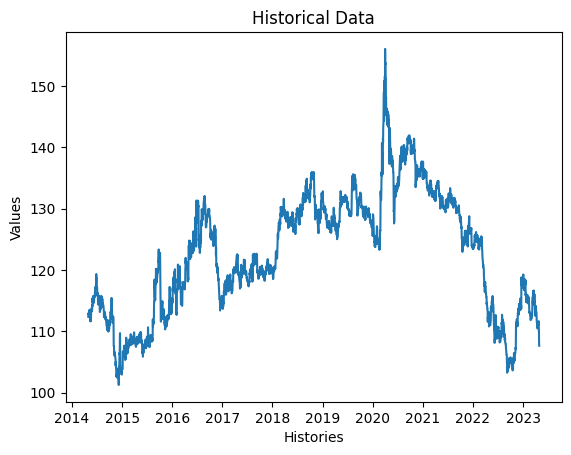

In [132]:
linechart(datasets)

## Normalisasi Data
- normalisasi data menjadi skala -1 hingga 1

In [133]:
import numpy as np

class MinMaxScaler:

    def __init__(self, min_val=-1,  max_val=1):
        self.min_val = min_val
        self.max_val = max_val
        self.min_data = None
        self.max_data = None

    def fit(self, data):
        self.min_data = min(data)
        self.max_data = max(data)
        config['DATA'][f'MIN_DATA'] = self.min_data
        config['DATA'][f'MAX_DATA'] = self.max_data
        with open(config_file, 'w') as file:
            yaml.dump(config, file)

    def transform(self, data):
        scaled_data = (data - self.min_data) / (self.max_data - self.min_data)
        scaled_data = scaled_data * (self.max_val - self.min_val) + self.min_val
        return scaled_data

    def inverse_transform(self, scaled_data, min_data=None, max_data=None):
        if min_data:
            self.min_data = min_data
        if max_data:
            self.max_data = max_data

        data = ( scaled_data - self.min_val ) / ( self.max_val - self.min_val )
        data = data * ( self.max_data - self.min_data ) + self.min_data
        return data

In [134]:
# scaling datasets
data_scaler = MinMaxScaler(min_val=-1, max_val=1)
data_scaler.fit(datasets['values'])
datasets['normalized'] = data_scaler.transform(datasets['values'])

In [135]:
datasets.head()

,values,normalized
timestamps,,
2014-04-30,112.348267,-0.595212
2014-05-01,112.972555,-0.572431
2014-05-02,112.685560,-0.582904
2014-05-03,112.763388,-0.580064
2014-05-04,112.763012,-0.580077


## Sliding Window

In [136]:
# Modul Sliding Window
def sliding_window(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[ i : i+window_size ])
        y.append(data[ i + window_size ])
    X = np.array(X)
    y = np.array(y)
    X_reshape = X.reshape(X.shape[0], X.shape[1], 1)
    y_reshape = y.reshape(y.shape[0], 1)
    return torch.from_numpy(X_reshape).type(torch.Tensor), torch.from_numpy(y_reshape).type(torch.Tensor)

In [137]:
## Sliding Window

for i in config["MODEL"]["INPUT_SIZE"]:
    vars()[f"X_slide_{i}"], vars()[f"y_slide_{i}"] = sliding_window(datasets.normalized, window_size=i)

In [138]:
X_slide_7.shape, X_slide_14.shape, X_slide_30.shape

(torch.Size([3236, 7, 1]),
 torch.Size([3229, 14, 1]),
 torch.Size([3213, 30, 1]))

## Data Spliting
- Split data yang telah didapatkan, menjadi 80% training dan 20% testing
- Visualisasi data yang telah dibagi
- Menghasilkan dataset sebanyak input yang diinginkan

In [139]:
# proses split data
for i in config["MODEL"]["INPUT_SIZE"]:
    size_ = vars()[f"X_slide_{i}"].shape[0]
    print("setup data", size_)
    Xdataset = vars()[f"X_slide_{i}"]
    ydataset = vars()[f"y_slide_{i}"]
    train_size = round(config['DATA']["TRAIN"] * size_)
    
    vars()[f"X_train_{i}"] = Xdataset[:train_size]
    vars()[f"X_test_{i}"]  = Xdataset[train_size:]

    vars()[f"y_train_{i}"] = ydataset[:train_size]
    vars()[f"y_test_{i}"]  = ydataset[train_size:]

setup data 3236
setup data 3229
setup data 3213


In [140]:
X_train_7.shape[0], X_test_7.shape[0]

(2589, 647)

In [141]:
X_train_14[:, :1, :1].flatten().numpy()

array([-0.5952125 , -0.5724307 , -0.58290386, ...,  0.06329837,
        0.06763846,  0.0667787 ], dtype=float32)

### Vis Datasets

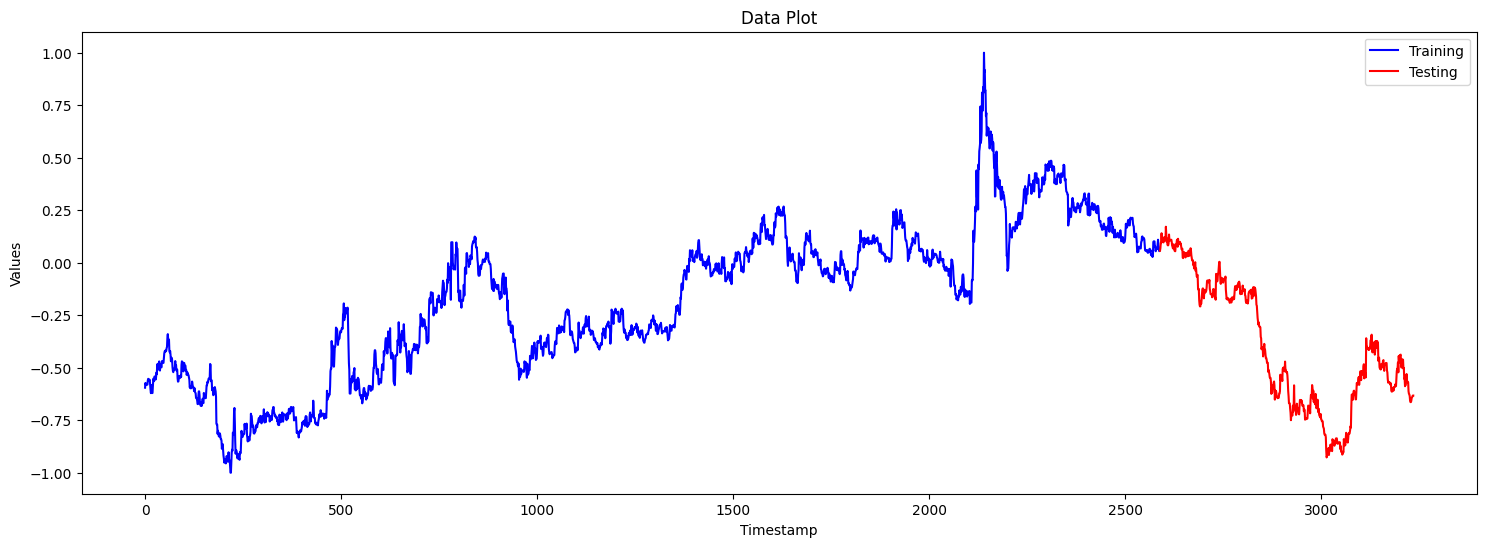

In [142]:
# proses visualisasi data
plt.figure(figsize=(18, 6))

# Mengambil data dari tensor dan mengubahnya menjadi array satu dimensi
train_data = X_train_7[:, 0, 0].flatten().numpy()
test_data = X_test_7[:, 0, 0].flatten().numpy()

# Mengatur posisi x untuk line chart
x_train = np.arange(len(train_data))
x_test = np.arange(len(train_data), len(train_data) + len(test_data))


# Membuat line chart
plt.plot(x_train, train_data, color='blue', label='Training')
plt.plot(x_test, test_data, color='red', label='Testing')


# Menambahkan label dan judul plot
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Data Plot')
plt.legend()

# Menampilkan plot
plt.show()

# Modeling

## Generic LSTM

In [51]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.lstms = nn.ModuleList()
        self.lstms.append(
            nn.LSTM(input_size, hidden_sizes[0])
        )

        for i in range(1, self.num_layers):
            self.lstms.append(
                nn.LSTM(hidden_sizes[i-1], hidden_sizes[i])
            )
        self.dropout = nn.Dropout(config['MODEL']['DROPOUT'])
        self.fc = nn.Linear(hidden_sizes[-1], output_size)
        self.init_weights()

    def init_weights(self):
        for i in range(self.num_layers):
            for name, param in self.lstms[i].named_parameters():
                if 'weight' in name:
                    if param.data.dim() > 1:
                        nn.init.xavier_normal_(param)
                    else:
                        nn.init.zeros_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)

    def forward(self, input):
        for i in range(self.num_layers):
            output, _ = self.lstms[i](input)
            input = output

        output = self.fc(output[:, -1, :])
        return output

## Uji Learning

In [146]:
# class UJI

class Evaluation:
    
    def __init__(self, prediction=[], actual=[]):
        self.prediction = prediction
        self.actual = actual

    def rmse(self):
        return np.sqrt(((self.prediction - self.actual) ** 2).mean())

    def mape(self):
        n_data = len(self.prediction)
        absolute_error = []
        percentage_error = []

        for i in range(n_data):
            absolute_error.append( abs(self.actual[i] - self.prediction[i]) )
            percentage_error.append( absolute_error[i] / abs(self.actual[i]) )
        mape = (sum(percentage_error) / len(self.actual)) * 100
        return mape

    def da(self):
        correct = 0
        total = len(self.actual)

        for i in range(total):
            change_actual = self.actual[i-1] - self.actual[i]
            change_predicted = self.prediction[i-1] - self.prediction[i]

            if (change_actual > 0 and change_predicted > 0) or ( change_actual < 0 and change_predicted < 0 ):
                correct += 1

        accuracy = correct / (total - 1) * 100
        return accuracy

    def r2(self):
        mean_actual = sum(self.actual) / len(self.actual)
        ss_total = sum((actual_value - mean_actual) ** 2 for actual_value in self.actual)
        ss_residual = sum((self.actual[i] - self.prediction[i]) ** 2 for i in range(len(self.actual)))
        r_squared = 1 - (ss_residual / ss_total)
        return r_squared


In [53]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 156.061702,
  'MIN_DATA': 101.255919,
  'SCC': 'JPY',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [57]:
for lr in config['MODEL']['LEARNING_RATE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[1],
        output_size=1
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_histories = []
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_7)
        loss = criterion(output, y_train_7)
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'wb') as f:
        pickle.dump(loss_histories, f)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/lr_{lr}.pth")

Epoch: 10/1000, Loss: 0.20045185089111328
Epoch: 20/1000, Loss: 0.12526865303516388
Epoch: 30/1000, Loss: 0.0970098152756691
Epoch: 40/1000, Loss: 0.06319566071033478
Epoch: 50/1000, Loss: 0.021516922861337662
Epoch: 60/1000, Loss: 0.008094142191112041
Epoch: 70/1000, Loss: 0.007968507707118988
Epoch: 80/1000, Loss: 0.004818273708224297
Epoch: 90/1000, Loss: 0.004432802554219961
Epoch: 100/1000, Loss: 0.003659440204501152
Epoch: 110/1000, Loss: 0.0032497625797986984
Epoch: 120/1000, Loss: 0.0029057590290904045
Epoch: 130/1000, Loss: 0.002666012616828084
Epoch: 140/1000, Loss: 0.0024708991404622793
Epoch: 150/1000, Loss: 0.0023183308076113462
Epoch: 160/1000, Loss: 0.002191349398344755
Epoch: 170/1000, Loss: 0.002082728547975421
Epoch: 180/1000, Loss: 0.0019864048808813095
Epoch: 190/1000, Loss: 0.0018992464756593108
Epoch: 200/1000, Loss: 0.0018193464493378997
Epoch: 210/1000, Loss: 0.0017454973421990871
Epoch: 220/1000, Loss: 0.0016769960056990385
Epoch: 230/1000, Loss: 0.001613337546

In [59]:
# import plotly.graph_objects as go

fig = go.Figure()
x = [x+1 for x in range(1000)]
# for lr in params["LR"]:
for lr in config['MODEL']["LEARNING_RATE"]:
    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'rb') as f:
        loss_histories = pickle.load(f)
    
        fig.add_trace(go.Scatter(x=x, y=loss_histories, mode='lines', name=f"loss histories of {lr}"))
        
        fig.update_layout(
            xaxis_title='epoch',
            yaxis_title='loss',
            title=f"Loss error {config['MODEL']['LEARNING_RATE']}",
            height=800
        )
fig.show()

## Uji Jumlah Feature Input dan Hidden Layer 1

In [60]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 156.061702,
  'MIN_DATA': 101.255919,
  'SCC': 'JPY',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [61]:
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_size in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1,
            hidden_sizes=[hidden_size],
            output_size=config['MODEL']['OUTPUT_SIZE']
        )
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=.001)

        loss_histories = []
        num_epochs = config['MODEL']['EPOCHS']
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(vars()[f"X_train_{window}"])
            loss = criterion(output, vars()[f"y_train_{window}"])
            loss.backward()
            optimizer.step()

            loss_histories.append(loss.item())

            if (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

        with open(f"models/{config['DATA']['SCC']}/hist_{window}_{hidden_size}.pkl", 'wb') as file:
            pickle.dump(loss_histories, file)
        torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{window}_{hidden_size}.pth")

Epoch: 10/100, Loss: 0.22215670347213745
Epoch: 20/100, Loss: 0.20107854902744293
Epoch: 30/100, Loss: 0.1791447550058365
Epoch: 40/100, Loss: 0.1549898386001587
Epoch: 50/100, Loss: 0.12793013453483582
Epoch: 60/100, Loss: 0.09818561375141144
Epoch: 70/100, Loss: 0.06817339360713959
Epoch: 80/100, Loss: 0.04537663236260414
Epoch: 90/100, Loss: 0.036237332969903946
Epoch: 100/100, Loss: 0.026878725737333298
Epoch: 10/100, Loss: 0.14064951241016388
Epoch: 20/100, Loss: 0.10801932215690613
Epoch: 30/100, Loss: 0.07435856014490128
Epoch: 40/100, Loss: 0.04392591491341591
Epoch: 50/100, Loss: 0.028656654059886932
Epoch: 60/100, Loss: 0.016844701021909714
Epoch: 70/100, Loss: 0.009285430423915386
Epoch: 80/100, Loss: 0.006927138194441795
Epoch: 90/100, Loss: 0.006510634906589985
Epoch: 100/100, Loss: 0.005950547754764557
Epoch: 10/100, Loss: 0.1431562304496765
Epoch: 20/100, Loss: 0.11129553616046906
Epoch: 30/100, Loss: 0.07470186799764633
Epoch: 40/100, Loss: 0.049786459654569626
Epoch: 5

### Evaluasi Hasil Input dan Hidden Layer ke 1
<ul>
    <li>Dilakukan dengan cara perulangan kombinasi dari jumlah input dan jumlah hidden pertama. </li>
    <li>kemudian dilakukan evaluasi dengan matriks RMSE, MAPE dan DA </li>
</ul>

In [71]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 156.061702,
  'MIN_DATA': 101.255919,
  'SCC': 'JPY',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

#### Rasio 1 hari

In [72]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_1 in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1, hidden_sizes=[hidden_1], output_size=1
        )
        model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth"))
        print("load model:", f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth")
        with torch.no_grad():
            predicted = model.forward(vars()[f"X_test_{window}"])

        predicted_denorm = data_scaler.inverse_transform(predicted)
        actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{window}"])
        
        eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
        buckets['model'].append(f"{window}_{hidden_1}")
        buckets['RMSE'].append(eval.rmse().item())
        buckets["MAPE"].append(eval.mape().item())
        buckets["DA"].append(eval.da())
        buckets["R2"].append(eval.r2().item())
        print(f"model {window}_{hidden_1}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/JPY/7_8.pth
model 7_8: rmse(2.8939993381500244) | mape(2.164301633834839) | da(43.808049535603715) | r2(tensor([0.8771]))
load model: models/JPY/7_16.pth
model 7_16: rmse(1.521722435951233) | mape(1.031779408454895) | da(44.27244582043344) | r2(tensor([0.9660]))
load model: models/JPY/7_32.pth
model 7_32: rmse(1.5238759517669678) | mape(1.058856725692749) | da(44.11764705882353) | r2(tensor([0.9659]))
load model: models/JPY/7_64.pth
model 7_64: rmse(1.2336325645446777) | mape(0.8351044058799744) | da(44.11764705882353) | r2(tensor([0.9777]))
load model: models/JPY/14_8.pth
model 14_8: rmse(3.080650568008423) | mape(2.258784055709839) | da(43.72093023255814) | r2(tensor([0.8603]))
load model: models/JPY/14_16.pth
model 14_16: rmse(1.7252306938171387) | mape(1.1828856468200684) | da(43.87596899224806) | r2(tensor([0.9562]))
load model: models/JPY/14_32.pth
model 14_32: rmse(1.4570190906524658) | mape(1.015807032585144) | da(45.58139534883721) | r2(tensor([0.9688]))
loa

In [73]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['BCC']}_{config['DATA']['SCC']}_input_layer1.csv")

In [74]:
results

,model,RMSE,MAPE,DA,R2
0,7_8,2.893999,2.164302,43.808050,0.877086
1,7_16,1.521722,1.031779,44.272446,0.966016
2,7_32,1.523876,1.058857,44.117647,0.965920
3,7_64,1.233633,0.835104,44.117647,0.977665
4,14_8,3.080651,2.258784,43.720930,0.860302
5,14_16,1.725231,1.182886,43.875969,0.956187
6,14_32,1.457019,1.015807,45.581395,0.968751
7,14_64,1.263842,0.877580,44.341085,0.976488
8,30_8,8.524624,6.276608,45.015576,-0.079490
9,30_16,1.896258,1.309656,43.925234,0.946585


#### Visualisasi best model

In [195]:
best_input = 7
best_hidden_1 = 64

In [196]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}.pth"))

with torch.no_grad():
    predicted = model.forward(vars()[f'X_test_{best_input}'])

In [197]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [200]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis=dict(
        title="values",
        tickformat=",.f2"
    ),
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=600
)
fig.show()

#### Rasio 10 hari

In [62]:
step_predict = 10

buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": []
}

for window in config['MODEL']['INPUT_SIZE']:

    for hidden_1 in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1, hidden_sizes=[hidden_1], output_size=1
        )
        model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth"))
        print("load model:", f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth")

        with torch.no_grad():
            predictions = []
            input_sequence = torch.Tensor(vars()[f"X_test_{window}"][-1:])  # Memulai dengan input terakhir
            for _ in range(10):  # Prediksi 5 langkah berikutnya
                prediction = model(input_sequence)
                predictions.append(prediction.item())
                print("input:", input_sequence, "predict:", prediction)
                # Mengubah hasil prediksi menjadi input untuk langkah berikutnya
                input_sequence = torch.cat((input_sequence, prediction.unsqueeze(0)), dim=1)
                input_sequence = input_sequence[:, -window:, :]
        
        predictions = np.array(predictions)
        predictions = torch.from_numpy(predictions)

        actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{window}"][:10])
        predicted_denorm = data_scaler.inverse_transform(predictions.unsqueeze(1))
        
        eval = Evaluation(actual=actual_denorm[:-5], prediction=predicted_denorm[5:])
        buckets['model'].append(f"{window}_{hidden_1}")
        buckets['RMSE'].append(eval.rmse().item())
        buckets["MAPE"].append(eval.mape().item())
        buckets["DA"].append(eval.da())
        print(f"model {window}_{hidden_1}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()})")

load model: models/USD/7_8.pth
input: tensor([[[0.3375],
         [0.3375],
         [0.3353],
         [0.3429],
         [0.3008],
         [0.2529],
         [0.2391]]]) predict: tensor([[0.0744]])
input: tensor([[[0.3375],
         [0.3353],
         [0.3429],
         [0.3008],
         [0.2529],
         [0.2391],
         [0.0744]]]) predict: tensor([[0.0624]])
input: tensor([[[0.3353],
         [0.3429],
         [0.3008],
         [0.2529],
         [0.2391],
         [0.0744],
         [0.0624]]]) predict: tensor([[0.0616]])
input: tensor([[[0.3429],
         [0.3008],
         [0.2529],
         [0.2391],
         [0.0744],
         [0.0624],
         [0.0616]]]) predict: tensor([[0.0615]])
input: tensor([[[0.3008],
         [0.2529],
         [0.2391],
         [0.0744],
         [0.0624],
         [0.0616],
         [0.0615]]]) predict: tensor([[0.0615]])
input: tensor([[[0.2529],
         [0.2391],
         [0.0744],
         [0.0624],
         [0.0616],
         [0.0615]

#### Visualization best model

In [64]:
model = LSTMModel(
    input_size=1, hidden_sizes=[64], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{30}_{64}.pth"))

with torch.no_grad():
    predictions = []
    input_sequence = torch.Tensor(X_test_30[-1:])  # Memulai dengan input terakhir

    for _ in range(7):  # Prediksi 5 langkah berikutnya
        prediction = model(input_sequence)
        print("norm pred:", prediction.item())

        pred_denorm = data_scaler.inverse_transform(prediction.item())
        print("denorm pred:", pred_denorm)
        print("redo pred:", data_scaler.transform(pred_denorm))
        predictions.append(data_scaler.transform(pred_denorm))
        # Mengubah hasil prediksi menjadi input untuk langkah berikutnya
        input_sequence = torch.cat((input_sequence, prediction.unsqueeze(0)), dim=1)
        input_sequence = input_sequence[:, -30:, :]

norm pred: 0.06849547475576401
denorm pred: 14212.287074830383
redo pred: 0.06849547475576401
norm pred: 0.05023278295993805
denorm pred: 14163.151302553713
redo pred: 0.05023278295993805
norm pred: 0.048266418278217316
denorm pred: 14157.860798377544
redo pred: 0.048266418278217316
norm pred: 0.048054568469524384
denorm pred: 14157.290816467255
redo pred: 0.048054568469524384
norm pred: 0.048031747341156006
denorm pred: 14157.22941622138
redo pred: 0.048031747341156006
norm pred: 0.04802928864955902
denorm pred: 14157.222801111639
redo pred: 0.04802928864955902
norm pred: 0.04802902415394783
denorm pred: 14157.222089486197
redo pred: 0.04802902415394783


In [65]:
predictions = np.array(predictions)
predictions = torch.from_numpy(predictions)

actual_denorm = data_scaler.inverse_transform(y_test_30[:7])
predicted_denorm = data_scaler.inverse_transform(predictions.unsqueeze(1))

In [66]:
eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

eval.mape().item(), eval.rmse().item(), eval.da()

(2.3758553583751274, 345.80210281590627, 83.33333333333334)

In [67]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predicted_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    title=f"Perbandingan hasil prediksi 30 hari",
    height=600
)
fig.show()

## Uji Hidden Layer 2

In [85]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 156.061702,
  'MIN_DATA': 101.255919,
  'SCC': 'JPY',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': '',
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [204]:
for hidden_size in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[best_hidden_1, hidden_size],
        output_size=config['MODEL']['OUTPUT_SIZE']
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    loss_histories = []
    num_epochs = config['MODEL']['EPOCHS']
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(vars()[f"X_train_{best_input}"])
        loss = criterion(output, vars()[f"y_train_{best_input}"])
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/hist_{best_input}_{best_hidden_1}_{hidden_size}.pkl", 'wb') as file:
        pickle.dump(loss_histories, file)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_size}.pth")

Epoch: 10/100, Loss: 0.11103716492652893
Epoch: 20/100, Loss: 0.0685773491859436
Epoch: 30/100, Loss: 0.03183172643184662
Epoch: 40/100, Loss: 0.01856241188943386
Epoch: 50/100, Loss: 0.012823336757719517
Epoch: 60/100, Loss: 0.009990866295993328
Epoch: 70/100, Loss: 0.008118501864373684
Epoch: 80/100, Loss: 0.0062563796527683735
Epoch: 90/100, Loss: 0.00485749077051878
Epoch: 100/100, Loss: 0.004007038660347462
Epoch: 10/100, Loss: 0.11202763766050339
Epoch: 20/100, Loss: 0.06085888668894768
Epoch: 30/100, Loss: 0.027735061943531036
Epoch: 40/100, Loss: 0.016338856890797615
Epoch: 50/100, Loss: 0.010469736531376839
Epoch: 60/100, Loss: 0.007814789190888405
Epoch: 70/100, Loss: 0.006722854450345039
Epoch: 80/100, Loss: 0.006016579456627369
Epoch: 90/100, Loss: 0.005374103784561157
Epoch: 100/100, Loss: 0.004800510127097368
Epoch: 10/100, Loss: 0.10465224832296371
Epoch: 20/100, Loss: 0.05386131629347801
Epoch: 30/100, Loss: 0.02052217908203602
Epoch: 40/100, Loss: 0.011735035106539726


### Evaluasi Hasil Hidden Layer 2

#### Rasio 1 hari

In [205]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}

for hidden_2 in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1, hidden_sizes=[best_hidden_1, hidden_2], output_size=1
    )
    model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}.pth"))
    print("load model:", f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}.pth")
    with torch.no_grad():
        predicted = model.forward(vars()[f"X_test_{best_input}"])

    predicted_denorm = data_scaler.inverse_transform(predicted)
    actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])
    
    eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
    buckets['model'].append(f"{best_input}_{best_hidden_1}_{hidden_2}")
    buckets['RMSE'].append(eval.rmse().item())
    buckets["MAPE"].append(eval.mape().item())
    buckets["DA"].append(eval.da())
    buckets['R2'].append(eval.r2().item())
    print(f"model {window}_{hidden_1}_{hidden_size}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/JPY/7_64_8.pth
model 14_64_64: rmse(1.4495360851287842) | mape(0.9933791160583496) | da(45.51083591331269) | r2(tensor([0.9692]))
load model: models/JPY/7_64_16.pth
model 14_64_64: rmse(1.5305367708206177) | mape(1.0724334716796875) | da(46.59442724458204) | r2(tensor([0.9656]))
load model: models/JPY/7_64_32.pth
model 14_64_64: rmse(1.2999205589294434) | mape(0.8816744089126587) | da(45.975232198142415) | r2(tensor([0.9752]))
load model: models/JPY/7_64_64.pth
model 14_64_64: rmse(1.2526124715805054) | mape(0.844974935054779) | da(45.82043343653251) | r2(tensor([0.9770]))


In [206]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['BCC']}_{config['DATA']['SCC']}_input_layer2.csv")

In [207]:
results

,model,RMSE,MAPE,DA,R2
0,7_64_8,1.449536,0.993379,45.510836,0.969164
1,7_64_16,1.530537,1.072433,46.594427,0.965621
2,7_64_32,1.299921,0.881674,45.975232,0.975201
3,7_64_64,1.252612,0.844975,45.820433,0.976973


#### Visualisasi best model

In [208]:
best_hidden_2 = 64

In [209]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}.pth"))

with torch.no_grad():
    predicted = model.forward(vars()[f"X_test_{best_input}"])

In [210]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [211]:
predict_denorm.shape, actual_denorm.shape

(torch.Size([647, 1]), torch.Size([647, 1]))

In [212]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=600
)
fig.show()

#### Rasio 30 hari

In [163]:
step_predict = 30

buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": []
}

for hidden_2 in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
    )
    model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}.pth"))
    print("load model:", f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}.pth")

    with torch.no_grad():
        predictions = []
        input_sequence = torch.Tensor(vars()[f"X_test_{best_input}"][-1:])  # Memulai dengan input terakhir
        for _ in range(30):  # Prediksi 5 langkah berikutnya
            prediction = model(input_sequence)
            predictions.append(prediction.item())
            # Mengubah hasil prediksi menjadi input untuk langkah berikutnya
            input_sequence = torch.cat((input_sequence, prediction.unsqueeze(0)), dim=1)
            input_sequence = input_sequence[:, -window:, :]
    
    predictions = np.array(predictions)
    predictions = torch.from_numpy(predictions)

    actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"][:30])
    predicted_denorm = data_scaler.inverse_transform(predictions.unsqueeze(1))
    
    eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
    buckets['model'].append(f"{window}_{hidden_1}_{hidden_2}")
    buckets['RMSE'].append(eval.rmse().item())
    buckets["MAPE"].append(eval.mape().item())
    buckets["DA"].append(eval.da())
    print(f"model {window}_{hidden_1}_{hidden_2}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()})")

load model: models/JPY/7_64_64.pth
model 14_64_8: rmse(1.49597237279445) | mape(1.0263147292660026) | da(10.344827586206897)
load model: models/JPY/7_64_64.pth
model 14_64_16: rmse(1.49597237279445) | mape(1.0263147292660026) | da(10.344827586206897)
load model: models/JPY/7_64_64.pth
model 14_64_32: rmse(1.49597237279445) | mape(1.0263147292660026) | da(10.344827586206897)
load model: models/JPY/7_64_64.pth
model 14_64_64: rmse(1.49597237279445) | mape(1.0263147292660026) | da(10.344827586206897)


In [164]:
pd.DataFrame(buckets)

,model,RMSE,MAPE,DA
0,14_64_8,1.495972,1.026315,10.344828
1,14_64_16,1.495972,1.026315,10.344828
2,14_64_32,1.495972,1.026315,10.344828
3,14_64_64,1.495972,1.026315,10.344828


#### Visualization best model

In [169]:
predic_size = 10
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}.pth"))

with torch.no_grad():
    predictions = []
    input_sequence = torch.Tensor(vars()[f'X_test_{best_input}'][-1:])  # Memulai dengan input terakhir
    for _ in range(predic_size):  # Prediksi 5 langkah berikutnya
        prediction = model(input_sequence)
        predictions.append(prediction.item())
        # print("input:", input_sequence, "result:", prediction)
        # Mengubah hasil prediksi menjadi input untuk langkah berikutnya
        input_sequence = torch.cat((input_sequence, prediction.unsqueeze(0)), dim=1)
        input_sequence = input_sequence[:, -9:, :]

In [170]:
predictions = np.array(predictions)
predictions = torch.from_numpy(predictions)

actual_denorm = data_scaler.inverse_transform(vars()[f'y_test_{best_input}'][:predic_size])
predicted_denorm = data_scaler.inverse_transform(predictions.unsqueeze(1))

In [171]:
eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

eval.mape().item(), eval.rmse().item(), eval.da()

(1.4149257039387135, 1.976631343472552, 44.44444444444444)

In [172]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predicted_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    title=f"Perbandingan hasil prediksi 30 hari",
    height=600
)
fig.show()

## Uji Optimizer

### Training Model SGD

In [119]:
best_input = 7
best_hidden_1 = 64
best_hidden_2 = 64

In [120]:
for hidden_size in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[best_hidden_1, hidden_size],
        output_size=config['MODEL']['OUTPUT_SIZE']
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=0.9, dampening=0.1)

    loss_histories = []
    num_epochs = config['MODEL']['EPOCHS']
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(vars()[f"X_train_{best_input}"])
        loss = criterion(output, vars()[f"y_train_{best_input}"])
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/hist_{best_input}_{best_hidden_1}_{hidden_size}_sgd.pkl", 'wb') as file:
        pickle.dump(loss_histories, file)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_size}_sgd.pth")

Epoch: 10/100, Loss: 0.1350928395986557
Epoch: 20/100, Loss: 0.13040511310100555
Epoch: 30/100, Loss: 0.1263972371816635
Epoch: 40/100, Loss: 0.12358754128217697
Epoch: 50/100, Loss: 0.12175434827804565
Epoch: 60/100, Loss: 0.12056838721036911
Epoch: 70/100, Loss: 0.11977245658636093
Epoch: 80/100, Loss: 0.11919941008090973
Epoch: 90/100, Loss: 0.11874952167272568
Epoch: 100/100, Loss: 0.11836600303649902
Epoch: 10/100, Loss: 0.1278737634420395
Epoch: 20/100, Loss: 0.12658677995204926
Epoch: 30/100, Loss: 0.125436469912529
Epoch: 40/100, Loss: 0.12458259612321854
Epoch: 50/100, Loss: 0.12398974597454071
Epoch: 60/100, Loss: 0.12358394265174866
Epoch: 70/100, Loss: 0.12330101430416107
Epoch: 80/100, Loss: 0.12309537082910538
Epoch: 90/100, Loss: 0.1229371726512909
Epoch: 100/100, Loss: 0.12280765175819397
Epoch: 10/100, Loss: 0.13749265670776367
Epoch: 20/100, Loss: 0.13257214426994324
Epoch: 30/100, Loss: 0.1283455193042755
Epoch: 40/100, Loss: 0.12537087500095367
Epoch: 50/100, Loss: 

### Evaluasi Model DLSTM - SGD

In [150]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}

for hidden_2 in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1, hidden_sizes=[best_hidden_1, hidden_2], output_size=1
    )
    model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}_sgd.pth"))
    print("load model:", f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}_sgd.pth")
    with torch.no_grad():
        predicted = model.forward(vars()[f"X_test_{best_input}"])

    predicted_denorm = data_scaler.inverse_transform(predicted)
    actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])
    
    eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
    buckets['model'].append(f"{best_input}_{best_hidden_1}_{hidden_2}")
    buckets['RMSE'].append(eval.rmse().item())
    buckets["MAPE"].append(eval.mape().item())
    buckets["DA"].append(eval.da())
    buckets['R2'].append(eval.r2().item())
    print(f"model {window}_{hidden_1}_{hidden_size}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/JPY/7_64_8_sgd.pth
model 14_64_64: rmse(10.070605278015137) | mape(7.543907165527344) | da(44.89164086687307) | r2(tensor([-0.4884]))
load model: models/JPY/7_64_16_sgd.pth
model 14_64_64: rmse(10.291769981384277) | mape(7.701664447784424) | da(45.04643962848297) | r2(tensor([-0.5545]))
load model: models/JPY/7_64_32_sgd.pth
model 14_64_64: rmse(10.45561695098877) | mape(7.7703962326049805) | da(44.42724458204334) | r2(tensor([-0.6044]))
load model: models/JPY/7_64_64_sgd.pth
model 14_64_64: rmse(10.552846908569336) | mape(7.828466415405273) | da(44.73684210526316) | r2(tensor([-0.6343]))


In [151]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['BCC']}_{config['DATA']['SCC']}_input_layer2_sgd.csv")
results

,model,RMSE,MAPE,DA,R2
0,7_64_8,10.070605,7.543907,44.891641,-0.488387
1,7_64_16,10.291770,7.701664,45.046440,-0.554479
2,7_64_32,10.455617,7.770396,44.427245,-0.604368
3,7_64_64,10.552847,7.828466,44.736842,-0.634346


### Visualisasi Hasil

In [155]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}_sgd.pth"))

with torch.no_grad():
    predicted = model.forward(vars()[f"X_test_{best_input}"])

In [156]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [157]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    yaxis=dict(
        title='value',
        tickformat=',.2f',
    ),
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=600
)
fig.show()